<a href="https://colab.research.google.com/github/vicmcl/e-commerce/blob/main/notebook_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from google.colab import drive
import sys

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.flush_and_unmount()
drive.mount(str(drive_path))

sys.path.append(str(drive_path / "My Drive" / "OCR" / "utils"))

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('white')
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_json(drive_path / "My Drive" / "OCR" / "4_Olist" / "orders.json").sort_values("time_since_order")

In [5]:
df[["time_since_order", "delay"]] = df[["time_since_order", "delay"]].applymap(lambda x: pd.Timedelta(x, unit="ms"))

In [6]:
df

,order_id,customer_unique_id,total_payments,mean_review_score,time_since_order,delay
6511,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,89.71,1.0,0 days 00:00:00,0 days 00:00:00
68317,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,222.03,5.0,0 days 21:14:16,0 days 00:00:00
62892,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,197.55,1.0,13 days 22:34:49,0 days 00:00:00
37735,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,80.38,2.0,16 days 02:00:09,0 days 00:00:00
22190,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,137.03,1.0,18 days 08:17:15,0 days 00:00:00
...,...,...,...,...,...,...
43966,71303d7e93b399f5bcd537d124c0bcfa,0eb1ee9dba87f5b36b4613a65074337c,109.34,1.0,744 days 19:22:26,0 days 00:00:00
74448,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,0.00,1.0,762 days 05:13:40,36 days 07:47:38
49869,809a282bbd5dbcabb6f2f724fca862ec,009b0127b727ab0ba422f6d9604487c7,40.95,1.0,764 days 02:05:59,0 days 00:00:00
89489,e5fa5a7210941f7d56d0208e4e071d35,4854e9b3feff728c13ee5fc7d1547e92,75.06,1.0,772 days 17:14:44,0 days 00:00:00


# Train sets definition

In [7]:
test_delays = range(5) # months
train_periods = [2, 4, 6] # months

In [8]:
train_orders = dict()
six_months = pd.Timedelta(180, unit='D')

# Extract the orders for every train period, from 6 months before the last order
for i in train_periods:
    train_period = pd.Timedelta(i * 30, unit='D')
    # Select the data points at least 6 months before the last order
    df_train = df[df["time_since_order"] > six_months]
    # Select the data points within the train period
    df_train = df_train[
        df_train["time_since_order"] < train_period + six_months
    ]
    train_orders[i] = df_train

# Test sets definition

In [9]:
test_orders = dict()
test_window = 2 # months

# Extract the orders for every 2-month test window
# from 6 to 2 months before the last order
for j in test_delays:
    # Set start and end times for the test window
    start_time = six_months - pd.Timedelta(j * 30, unit='D')
    end_time = start_time - pd.Timedelta(test_window * 30, unit='D')
    # Filter the data points in the test window
    df_test = df[df["time_since_order"] < start_time]
    df_test = df_test[df_test["time_since_order"] > end_time]
    test_orders[j] = df_test

# Scaler & imputer

In [10]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

# Aggregation by customer and standardization

In [39]:
def customer_aggregation(data):

    # Aggregation by customer
    data = data.groupby("customer_unique_id").agg(
        {
            "order_id": "count",
            "total_payments": "sum",
            "mean_review_score": "mean",
            "time_since_order": "min",
            "delay": "mean",
        }
    )

    # Set column names
    data.columns = [
        "n_orders",
        "total_payments",
        "mean_review_score",
        "time_since_order",
        "mean_delay",
    ]

    # Impute mean value to review score
    data["mean_review_score"] = imputer.fit_transform(
    np.array(data["mean_review_score"]).reshape(-1, 1)
    )

    # Convert datetime to seconds
    data[["time_since_order", "mean_delay"]] = (
        data[["time_since_order", "mean_delay"]]
        .applymap(lambda cell: cell.total_seconds())
    )

    # Log tranformation
    data[["n_orders", "total_payments"]] = (
        data[["n_orders", "total_payments"]]
        .applymap(lambda cell: np.log1p(cell))
    )

    # Standardization
    for col in data.columns:
        data[col] = scaler.fit_transform(
            np.array(data[col]).reshape(-1, 1)
        )

    return data

In [40]:
train_customers = dict()

for key in train_orders.keys():
    tr = train_orders[key]
    train_customers[key] = customer_aggregation(tr)

In [41]:
test_customers = dict()

for key in test_orders.keys():
    tt = test_orders[key]
    test_customers[key] = customer_aggregation(tt)

# K-Means

In [42]:
kmeans_model = KMeans(n_clusters=5, random_state=42)

sim_data = dict()

for t_train in train_periods:
    print("Train period:", t_train, "months" )
    train_set = train_customers[t_train]

    # K-means on train_set and store in df_cluster
    train_clusters = kmeans_model.fit_predict(train_set)

    test_clusters = dict()
    for t_delay in test_delays:
        print("Delay test:", t_delay, "months")
        test_set = test_customers[t_delay].copy()

        # K-means on test_set and store in df_cluster
        test_clusters[f"test_delay_{t_delay}"] = kmeans_model.predict(test_set)


    sim_data[f"train_period_{t_train}"] = (train_clusters, test_clusters)
    print("---------------------")

Train period: 2 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------
Train period: 4 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------
Train period: 6 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------


# Adjusted rand score

In [43]:
# Adjusted rand score between each train and test sets
ars = pd.DataFrame()

# Train periods: 2, 4, 6 months
for train_period in sim_data.keys():

    # Test after 2 to 6 months
    for test_delay in sim_data[train_period][1].keys():
        train_set = sim_data[train_period][0]
        test_set = sim_data[train_period][1][test_delay]

        # Number of data points
        n_sample = min(train_set.shape[0], test_set.shape[0])

        # Sample train or test sets while keeping the cluster proportions
        _, sampled_train, _, _ = train_test_split(
            train_set,
            train_set,
            test_size=n_sample - 5,
            stratify=train_set,
            random_state=42
        )
        _, sampled_test, _, _ = train_test_split(
            test_set,
            test_set,
            test_size=n_sample - 5,
            stratify=test_set,
            random_state=42
        )
        # Sort by cluster for comparison
        sampled_train = np.sort(sampled_train)
        sampled_test = np.sort(sampled_test)

        # Fill the DataFrame for adjusted rand score
        ars.loc[test_delay[-1], train_period[-1]] = adjusted_rand_score(
            sampled_train, sampled_test
        )

ars = ars.astype(float).iloc[::-1]

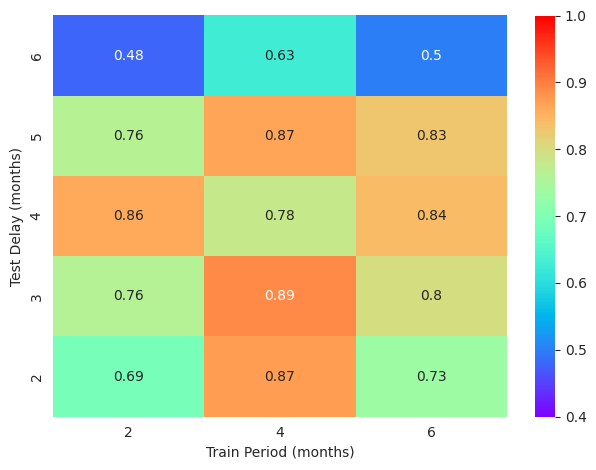

In [44]:
# Heatmap: adjusted rand score = f(train period, test delay)
cm = sns.heatmap(ars, cmap="rainbow", annot=True, vmin=0.4, vmax=1)
cm.set(xlabel="Train Period (months)" , ylabel="Test Delay (months)")
plt.tight_layout()